# micrograd skeleton (add, mul, tanh only)

Fill in the TODOs to build your own tiny autograd engine (Karpathy-style).

Keep the API minimal: `Value` objects support `+`, `*`, `tanh()`, and backprop via `backward()`.

In [3]:
# Utility imports. Nothing fancy needed.
import math
from typing import Iterable, Set, Callable


In [ ]:
class Value:
    """Scalar value with a tiny autograd tape. Fill in the TODOs."""

    def __init__(self, data: float, _children: Iterable["Value"] = (), _op: str = "", label: str = ""):
        self.data = float(data)
        self.grad = 0.0
        self._backward: Callable[[], None] = lambda: None  # populated by ops
        self._prev: Set[Value] = set(_children)
        self._op = _op  # e.g. '+', '*', 'tanh'
        self.label = label

    # ------------ core ops ------------
    def __add__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # d(a+b)/da = 1, d(a+b)/db = 1
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other: "Value") -> "Value":
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            # product rule: d(xy)/dx = y, d(xy)/dy = x
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def tanh(self) -> "Value":
        t = math.tanh(self.data)
        out = Value(t, (self,), "tanh")

        def _backward():
            # derivative of tanh is (1 - t^2)
            self.grad += (1 - t * t) * out.grad

        out._backward = _backward
        return out

    def backward(self) -> None:
        """
        Backprop through the graph starting from this node.
        Steps to fill in:
        1) Build topological ordering of the subgraph.
        2) Set self.grad = 1.0 (dself/dself).
        3) Traverse nodes in reverse topo order, calling each _backward().
        """
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __radd__(self, other: "Value") -> "Value":
        return self + other

    def __rmul__(self, other: "Value") -> "Value":
        return self * other

    def __repr__(self) -> str:
        return f"Value(data={self.data:.4f}, grad={self.grad:.4f}, op='{self._op}', label='{self.label}')"


In [5]:
# --- Graph visualization helpers (optional) ---
try:
    from graphviz import Digraph
except ImportError as e:
    Digraph = None
    print("Install graphviz first: brew install graphviz && pip install graphviz")
    print("ImportError:", e)

def trace(root):
    """Collect all nodes and edges in the graph ending at root."""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """Render a Graphviz visualization of the computation graph."""
    if Digraph is None:
        raise ImportError("graphviz is not installed; see message above")
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label}|data={n.data:.3f}|grad={n.grad:.3f}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


Value(data=1.0000, grad=0.0197, op='', label='a') Value(data=2.0000, grad=0.0099, op='', label='b') Value(data=1.0000, grad=0.0099, op='', label='c') Value(data=3.0000, grad=0.0099, op='+', label='') Value(data=0.9951, grad=1.0000, op='tanh', label='')


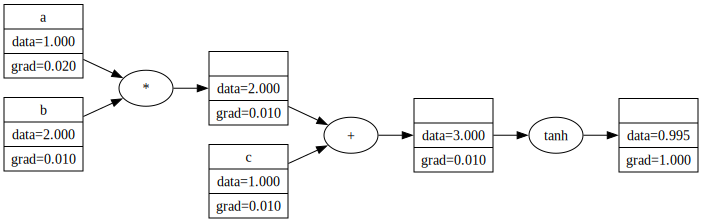

In [12]:
# Playground: after filling in TODOs, run a tiny expression and backprop.
a = Value(1.0, label='a')
b = Value(2.0, label='b')
c = Value(1.0, label='c')
d = a * b + c
e = d.tanh()
e.backward()
print(a, b, c, d, e)
draw_dot(e)
